# G2Net Gravitational Wave Detection

## Setup

### Imports

## Determine Environment

In [1]:
import socket
KAGGLE = True
if socket.gethostname() == "computerfon-linux":
    KAGGLE = False

In [68]:
if KAGGLE:
    !pip install -q pycbc
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycbc
from scipy import signal
from tqdm.notebook import tqdm
import cv2
%matplotlib inline

### Params

In [3]:
DATA_PATH = "../input/g2net-gravitational-wave-detection"
SEED = 69420
FOLDS = 16

## EDA

In [4]:
train_df = pd.read_csv(f"{DATA_PATH}/training_labels.csv")
train_df["path"] = train_df.id.map(lambda x: f"{DATA_PATH}/train/{x[0]}/{x[1]}/{x[2]}/{x}.npy")
train_df.head()

,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...


In [5]:
def get_data(path):
    return np.load(path)

In [6]:
import socket
print(socket.gethostname())
train_df.head()



computerfon-linux


,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...


In [13]:
path = train_df.path[0]

def get_qtransform(path):
    data = get_data(path)
    q_vec = []
    for i in range(3):
        vec = data[i]
        ts = pycbc.types.TimeSeries(vec, epoch=0, delta_t=1.0/2048)

        # whiten the data (i.e. normalize the noise power at different frequencies)
        ts = ts.whiten(0.125, 0.125)

        # calculate the qtransform
        time, freq, power = ts.qtransform(15.0/2048, logfsteps=256, qrange=(10, 10), frange=(20, 512))

        power -=power.min()
        power /=power.max()
        q_vec.append(power)
    return np.dstack(q_vec)

def get_img_qtransform(path):
    q_vec = get_qtransform(path)*255
    return q_vec.astype(np.uint8)

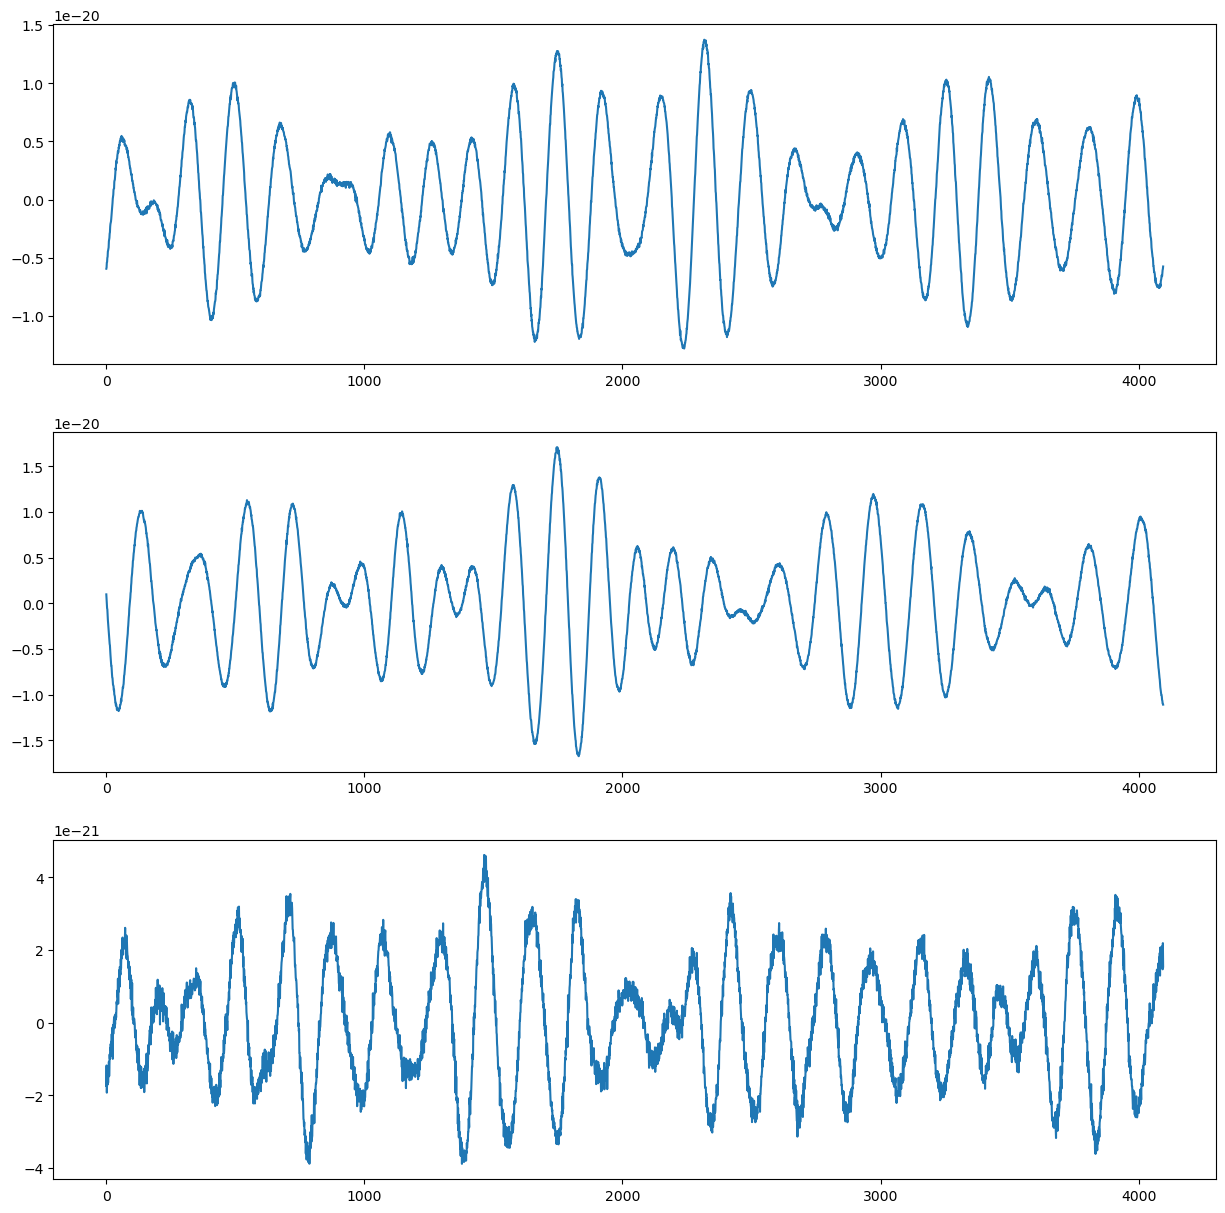

In [14]:
data = get_data(train_df.path.values[0])

fig, ax = plt.subplots(3, 1, figsize=(15, 15))

for i in range(3):
    ax[i].plot(data[i])
plt.show()

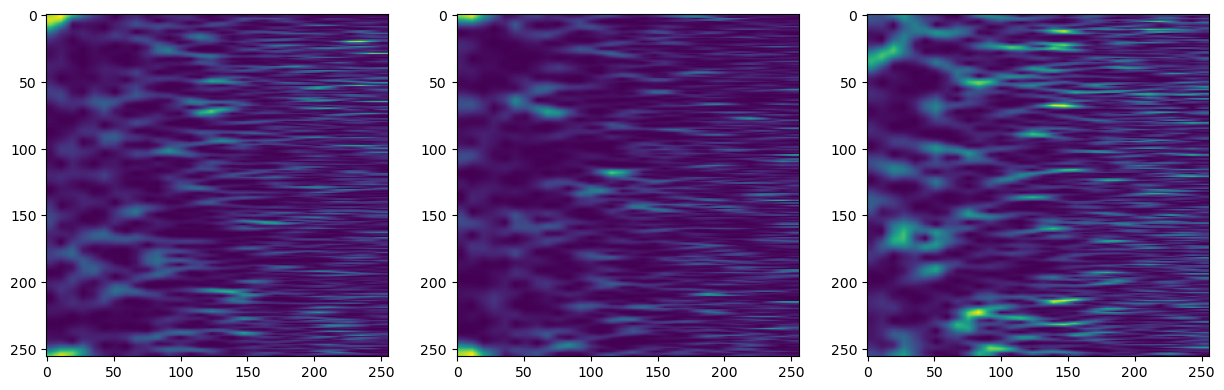

In [15]:
power = get_img_qtransform(train_df.path.values[0])

fig, ax = plt.subplots(1,3 ,figsize = (15, 5))

for i in range(3):
    ax[i].imshow(power[..., i].astype(np.float32).T)
plt.show()

In [18]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
train_df["fold"] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df["target"])):
    train_df.loc[val_idx, "fold"] = fold
train_df.groupby(["fold", "target"])["id"].count()

fold  target
0     0         17504
      1         17496
1     0         17504
      1         17496
2     0         17504
      1         17496
3     0         17504
      1         17496
4     0         17504
      1         17496
5     0         17504
      1         17496
6     0         17504
      1         17496
7     0         17504
      1         17496
8     0         17504
      1         17496
9     0         17504
      1         17496
10    0         17505
      1         17495
11    0         17505
      1         17495
12    0         17505
      1         17495
13    0         17505
      1         17495
14    0         17505
      1         17495
15    0         17505
      1         17495
Name: id, dtype: int64

## Save to TFRecords

In [17]:
import tensorflow as tf

### Functions

In [20]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte"""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # Byteslist won't unpack a string from an EagerTensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [21]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [22]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [75]:
def train_serialize_example(feature0, feature1, feature2):
    feature = {
        "image": _bytes_feature(feature0),
        "image_id": _bytes_feature(feature1),
        "target": _int64_feature(feature2)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [ ]:
show=True

folds = sorted(train_df.fold.unique().tolist())
for fold in tqdm(folds):
    if KAGGLE:
        if fold not in list((range(10,12))):
            continue
    fold_df = train_df[train_df.fold==fold]
    if show:
        print()
        print(f"Writing TFRecord of fold {fold}")
        filepath = f"train{fold:02}-{fold_df.shape[0]}.tfrec"
    with tf.io.TFRecordWriter(filepath) as writer:
        samples = fold_df.shape[0]
        it = tqdm(range(samples)) if show else range(samples)
        for k in it:
            row = fold_df.iloc[k,:]
            image = get_img_qtransform(row["path"])[...,::-1]
            image_id = row["id"]
            target = np.array(row["target"], dtype=np.uint8)
            example = train_serialize_example(
                cv2.imencode(".png", image)[1].tobytes(),
                str.encode(image_id),
                target
            )
            writer.write(example)
        if show:
            filename = filepath.split("/")[-1]
            filesize = os.path.getsize(filepath)/10**6
            print(f"{filename} : {np.around(filesize, 2)} MB")

  0%|          | 0/16 [00:00<?, ?it/s]


Writing TFRecord of fold 0


  0%|          | 0/35000 [00:00<?, ?it/s]